# Retrieve Images from nutrition5k dataset

The following scripts will copy `1000` valid dishes folder from `nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead`.


In [ ]:
import pandas as pd
import os
import subprocess

In [23]:
raw_data = pd.read_csv("./metadata/nutrition5k_dataset_metadata_dish_metadata_cafe1.csv", on_bad_lines='skip')
raw_data.head()

,dish_1561662216,300.794281,193.000000,12.387489,28.218290,18.633970,ingr_0000000508,soy sauce,3.398568,1.80124104,...,0.000424822,0.019754223,0.00424822,ingr_0000000513,millet,3.414345,4.06307055,0.03414345,0.809199765,0.119502075
0,dish_1562688426,137.569992,88.0,8.256000,5.190000,10.297000,ingr_0000000433,roasted potatoes,17.000000,23.970000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,dish_1561662054,419.438782,292.0,23.838249,26.351543,25.910593,ingr_0000000312,pepper,0.300716,0.120286,...,0.0,0.0,0.0,ingr_0000000524,parsley,0.752816,0.279295,0.006023,0.04818,0.021832
2,dish_1562008979,382.936646,290.0,22.224644,10.173570,35.345387,ingr_0000000448,jalapenos,0.192961,0.055959,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,dish_1560455030,20.590000,103.0,0.148000,4.625000,0.956000,ingr_0000000471,cherry tomatoes,55.000000,9.900000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,dish_1558372433,74.360001,143.0,0.286000,0.429000,20.020000,ingr_0000000453,deprecated,143.000000,74.360000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
dishes = raw_data.iloc[:, 0]
dishes_added = []

In [27]:
count = 0
destination_dir = './imagery/realsense_overhead'
for dish in dishes:
  try:
    # Copy the dish folder
    subprocess.run(['gsutil', 'cp', '-r', f'gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/{dish}', destination_dir], check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    print(f"Copied {dish}")
    count += 1
    dishes_added.append(dish)
    print("Current Count:", count)
  except subprocess.CalledProcessError as e:
    print(f"Error copying {dish}: {e}")

  if count == 1000:
    break

Error copying dish_1562688426: Command '['gsutil', 'cp', '-r', 'gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/dish_1562688426', './imagery/realsense_overhead']' returned non-zero exit status 1.
Copied dish_1561662054
Current Count: 1
Copied dish_1562008979
Current Count: 2
Copied dish_1560455030
Current Count: 3
Copied dish_1558372433
Current Count: 4
Error copying dish_1563379132: Command '['gsutil', 'cp', '-r', 'gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/dish_1563379132', './imagery/realsense_overhead']' returned non-zero exit status 1.
Copied dish_1565640549
Current Count: 5
Copied dish_1563207364
Current Count: 6
Copied dish_1561575474
Current Count: 7
Error copying dish_1550795690: Command '['gsutil', 'cp', '-r', 'gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/dish_1550795690', './imagery/realsense_overhead']' returned non-zero exit status 1.
Copied dish_1563216717
Current Count: 8
Copied dish_15659725

In [24]:
!rm -r ./imagery/realsense_overhead/dish*

# Data Processing

Reads the `rgb.png` image from all the dish folders.
Then it uses `cv2` to convert the image into a 3D array with its respective RGB values.  

In [1]:
import pandas as pd
import numpy as np
import os
import subprocess
import cv2

In [2]:
def process_image(image_path):
    image = cv2.imread(image_path)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return rgb_image

In [3]:
base_dir = "./imagery/realsense_overhead"
dishes_added = []
processed_images = {}
for directory in os.listdir(base_dir):
    directory_path = os.path.join(base_dir, directory)

    if os.path.isdir(directory_path):
        dishes_added.append(directory)
        rgb_image_path = os.path.join(directory_path, "rgb.png")
        if os.path.isfile(rgb_image_path):
            rgb_image = process_image(rgb_image_path)
            processed_images[directory] = rgb_image
        else:
            print(f"Warning: RGB image not found in directory {directory}")

In [4]:
IMAGE_SIZE = processed_images["dish_1556575558"].shape
IMAGE_SIZE

(480, 640, 3)

In [5]:
processed_images_df = pd.DataFrame([(k, v.flatten()) for k, v in processed_images.items()], columns=['dish_id', 'image'])

In [6]:
raw_data = pd.read_csv("./metadata/nutrition5k_dataset_metadata_dish_metadata_cafe1.csv", on_bad_lines='skip', header=None, usecols=range(6))
data = raw_data[raw_data[0].isin(dishes_added)]
data.columns = ['dish_id', 'calories', 'mass', 'fat', 'carb', 'protein']
data.head()

,dish_id,calories,mass,fat,carb,protein
2,dish_1561662054,419.438782,292.0,23.838249,26.351543,25.910593
3,dish_1562008979,382.936646,290.0,22.224644,10.173570,35.345387
4,dish_1560455030,20.590000,103.0,0.148000,4.625000,0.956000
5,dish_1558372433,74.360001,143.0,0.286000,0.429000,20.020000
7,dish_1565640549,45.482903,139.0,1.568471,7.043886,2.641478


In [7]:
data = data.merge(processed_images_df, how='left', on='dish_id')
data.head()

,dish_id,calories,mass,fat,carb,protein,image
0,dish_1561662054,419.438782,292.0,23.838249,26.351543,25.910593,"[122, 123, 112, 123, 124, 113, 124, 125, 114, ..."
1,dish_1562008979,382.936646,290.0,22.224644,10.173570,35.345387,"[110, 110, 104, 112, 112, 106, 105, 106, 100, ..."
2,dish_1560455030,20.590000,103.0,0.148000,4.625000,0.956000,"[133, 136, 137, 135, 138, 139, 138, 138, 138, ..."
3,dish_1558372433,74.360001,143.0,0.286000,0.429000,20.020000,"[50, 47, 44, 51, 48, 45, 54, 51, 48, 51, 48, 4..."
4,dish_1565640549,45.482903,139.0,1.568471,7.043886,2.641478,"[226, 234, 249, 225, 233, 248, 225, 233, 250, ..."


# Create X_train, y_train, X_test and y_test

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
def reshape_data(X, Y):
  X_reshape = []
  y_reshape = []
  for x in X:
    x = x.reshape(-1,1)
    x = x.reshape(IMAGE_SIZE)
    X_reshape.append(x)
  for y in Y:
    y = y.reshape(-1, 1)
    y = y.reshape(-1, 1)
    y_reshape.append(y)
  return np.array(X_reshape), np.array(y_reshape)

In [10]:
train, test = train_test_split(data, train_size=0.8, random_state=0)

In [11]:
train, validate = train_test_split(train, train_size=0.9, random_state=00)

In [12]:
X_train = train['image'].values
y_train = train[['mass', 'calories', 'fat', 'protein', 'carb']].values
X_train, y_train = reshape_data(X_train, y_train)

In [13]:
X_validate = validate['image'].values
y_validate = validate[['mass', 'calories', 'fat', 'protein', 'carb']].values
X_validate, y_validate = reshape_data(X_validate, y_validate)

In [14]:
X_test = test['image'].values
y_test = test[['mass', 'calories', 'fat', 'protein', 'carb']].values
X_test, y_test = reshape_data(X_test, y_test)

# Create Model

In [15]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [16]:
def create_model(input_shape):
    model = Sequential()

    # Convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Flatten layer
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))

    # Output layer
    model.add(Dense(5, activation='linear'))  # 5 neurons for mass, calories, fats, protein, carbs

    return model

# Train Model

Create a model that uses `adam` optimizer and loss function as `MSE`

In [21]:
epochs = 10
batch_size = 32

In [22]:
# Create the model
model = create_model(IMAGE_SIZE)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [23]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_validate, y_validate))

Epoch 1/10
23/23 [==============================] - 536s 23s/step - loss: 2988249.2500 - mae: 527.0853 - val_loss: 14337.3750 - val_mae: 68.6194
Epoch 2/10
23/23 [==============================] - 534s 23s/step - loss: 10936.3252 - mae: 57.5845 - val_loss: 10944.2432 - val_mae: 61.7273
Epoch 3/10
23/23 [==============================] - 534s 23s/step - loss: 9212.5615 - mae: 50.5626 - val_loss: 7849.0962 - val_mae: 49.6648
Epoch 4/10
23/23 [==============================] - 543s 24s/step - loss: 7811.9033 - mae: 48.1146 - val_loss: 8209.3125 - val_mae: 45.4976
Epoch 5/10
23/23 [==============================] - 544s 24s/step - loss: 6864.0439 - mae: 43.5169 - val_loss: 5597.7505 - val_mae: 40.1843
Epoch 6/10
23/23 [==============================] - 542s 24s/step - loss: 6033.1089 - mae: 40.8322 - val_loss: 5271.3140 - val_mae: 40.8006
Epoch 7/10
23/23 [==============================] - 514s 22s/step - loss: 5069.8057 - mae: 39.3188 - val_loss: 5150.1631 - val_mae: 40.5628
Epoch 8/10
23

In [24]:
model.evaluate(X_test, y_test)

7/7 [==============================] - 39s 6s/step - loss: 5837.5933 - mae: 41.6706


# Loss Function

For the model above, we use MSE as the loss function to train the model.\
Now we try out the loss function that was provided in the google paper.

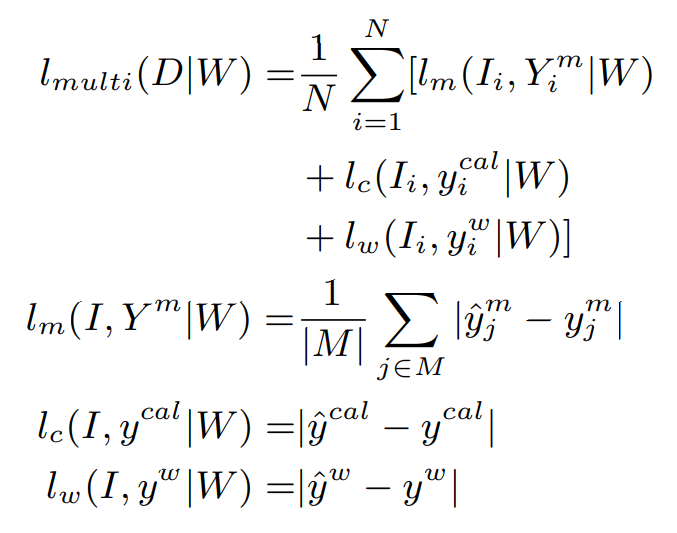

In [20]:
import tensorflow as tf

In [21]:
y_test = y_test.reshape(200, 5)
y_test.shape

(200, 5)

In [22]:
# output = [calories, mass, fat, carb, protein]

def multi_loss(actual, pred):
  actual = tf.cast(tf.squeeze(actual), tf.float64)
  pred = tf.cast(tf.squeeze(pred), tf.float64)
  temp = tf.abs(actual - pred)
  l_macronutrient = tf.reduce_sum(temp[:, -3:], axis=1) / 3
  loss = temp[:, 0] + temp[:, 1] + l_macronutrient
  return tf.cast(tf.reduce_sum(loss), tf.float64) / tf.cast(len(loss), tf.float64)

# multi_loss(y_test, y_pred)

# Train Model

Create a model that uses `adam` optimizer and loss function as `multi_loss`

In [23]:
epochs = 10
batch_size = 32

In [24]:
# Create the model
model = create_model(IMAGE_SIZE)

# Compile the model
model.compile(optimizer='adam', loss=multi_loss, metrics=['mae', multi_loss])

In [25]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_validate, y_validate))

Epoch 1/10
23/23 [==============================] - 528s 23s/step - loss: 1642.5011 - mae: 445.9766 - multi_loss: 1611.6531 - val_loss: 194.5550 - val_mae: 45.2742 - val_multi_loss: 187.9411
Epoch 2/10
23/23 [==============================] - 530s 23s/step - loss: 203.5768 - mae: 46.3917 - multi_loss: 202.9064 - val_loss: 197.8557 - val_mae: 47.0880 - val_multi_loss: 190.4845
Epoch 3/10
23/23 [==============================] - 524s 23s/step - loss: 187.5918 - mae: 43.5720 - multi_loss: 187.0051 - val_loss: 187.8497 - val_mae: 42.9883 - val_multi_loss: 181.1062
Epoch 4/10
23/23 [==============================] - 527s 23s/step - loss: 169.1219 - mae: 37.9449 - multi_loss: 169.9573 - val_loss: 200.4417 - val_mae: 45.1472 - val_multi_loss: 193.0103
Epoch 5/10
23/23 [==============================] - 506s 22s/step - loss: 157.8090 - mae: 36.1066 - multi_loss: 156.7511 - val_loss: 171.1817 - val_mae: 38.6653 - val_multi_loss: 165.0728
Epoch 6/10
23/23 [==============================] - 461s 

In [27]:
model.evaluate(X_test, y_test)

7/7 [==============================] - 41s 5s/step - loss: 182.3864 - mae: 41.4079 - multi_loss: 184.1156


[182.38641357421875, 41.407928466796875, 184.11561584472656]

# Train Model

Create a model that uses `RMSProp` optimizer and loss function as `multi_loss`

In [23]:
epochs = 10
batch_size = 32

In [24]:
# Create the model
model = create_model(IMAGE_SIZE)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4, momentum=0.9, weight_decay=0.9, epsilon=1.0)

# Compile the model
model.compile(optimizer='adam', loss=multi_loss, metrics=['mae', multi_loss])

In [ ]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_validate, y_validate))

Epoch 1/10
 3/23 [==>...........................] - ETA: 7:43 - loss: 6511.5864 - mae: 1574.5873 - multi_loss: 6511.5864

In [ ]:
model.evaluate(X_test, y_test)